In [2]:
#CELL 1 — IMPORT REQUIRED LIBRARIES
# ============================================================
# Data handling
import pandas as pd
import numpy as np


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


# Plot style
sns.set(style="whitegrid")

In [3]:
# CELL 2 — LOAD DATASET FROM KAGGLE INPUT PATH
# ============================================================
# Correct Kaggle dataset path
file_path = "/kaggle/input/online-retail-uk-data/online_retail_II.xlsx"


# Load only the 2009–2010 sheet
# This dataset contains customer transactions


df = pd.read_excel(file_path, sheet_name="Year 2009-2010")


# Display first 5 rows to confirm correct loading
print("Dataset Preview:")
df.head()




Dataset Preview:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
# CELL 3 — BASIC DATA EXPLORATION
# ============================================================
# View dataset dimensions (rows, columns)
print("Dataset Shape:", df.shape)


# View column information & missing values
print("\nDataset Info:")
df.info()


# View statistical summary of numerical columns
print("\nStatistical Summary:")
df.describe()

Dataset Shape: (525461, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB

Statistical Summary:


,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [5]:
# CELL 4 — DATA CLEANING
# ============================================================
# Remove rows with missing Customer ID (cannot segment without customer identity)
df = df[df['Customer ID'].notna()]


# Remove cancelled invoices (Invoice numbers starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]


# Remove negative or zero quantity and price (invalid transactions)
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]


print("Data cleaned successfully!")
print("New shape:", df.shape)

Data cleaned successfully!
New shape: (407664, 8)


In [6]:
# CELL 5 — FEATURE ENGINEERING: TOTAL TRANSACTION VALUE
# ============================================================
# Create TotalPrice feature = Quantity × Price


df['TotalPrice'] = df['Quantity'] * df['Price']


# Preview dataset with new feature
df[['Quantity', 'Price', 'TotalPrice']].head()

,Quantity,Price,TotalPrice
0,12,6.95,83.4
1,12,6.75,81.0
2,12,6.75,81.0
3,48,2.10,100.8
4,24,1.25,30.0


In [7]:
# CELL 6 — CONVERT INVOICE DATE TO DATETIME
# ============================================================
# Convert InvoiceDate to datetime format for date calculations


df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


print("InvoiceDate converted successfully")

InvoiceDate converted successfully


In [8]:
# CELL 7 — RFM FEATURE ENGINEERING
# ============================================================
# -------------------------
# R = Recency (How recently did the customer purchase?)
# F = Frequency (How often do they purchase?)
# M = Monetary (How much do they spend?)
# -------------------------


# Calculate Recency
max_date = df['InvoiceDate'].max()
df['Recency'] = (max_date - df['InvoiceDate']).dt.days


# Calculate Frequency per customer
frequency = df.groupby('Customer ID')['Invoice'].nunique()


# Calculate Monetary value per customer
monetary = df.groupby('Customer ID')['TotalPrice'].sum()


# Combine RFM metrics into one table
rfm = pd.concat([frequency, monetary], axis=1)
rfm.columns = ['Frequency', 'Monetary']


# Assign Recency values
rfm['Recency'] = df.groupby('Customer ID')['Recency'].min()


print("RFM Table Preview:")
rfm.head()

RFM Table Preview:


,Frequency,Monetary,Recency
Customer ID,,,
12346.0,11,372.86,164
12347.0,2,1323.32,2
12348.0,1,222.16,73
12349.0,3,2671.14,42
12351.0,1,300.93,10


In [9]:
# CELL 8 — FEATURE SCALING
# ============================================================
# Standardize features to ensure fair clustering


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


print("Features successfully scaled")

Features successfully scaled


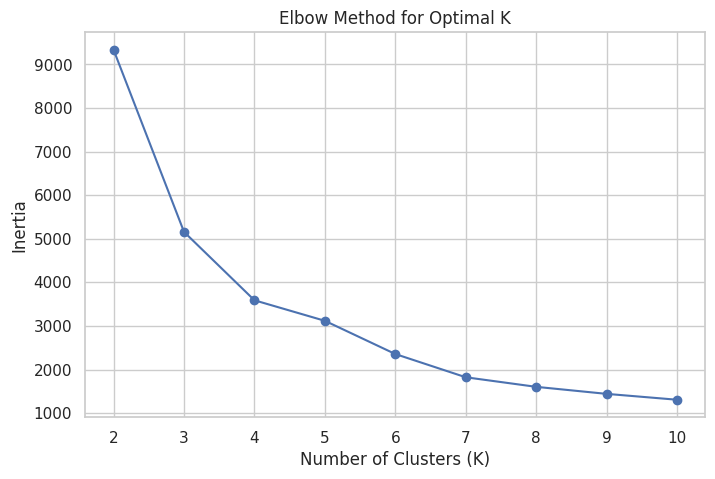

In [14]:
# CELL 9 — FIND OPTIMAL NUMBER OF CLUSTERS (ELBOW METHOD)
# ============================================================
inertia = []


for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8,5))
plt.plot(range(2,11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [16]:
# CELL 10 — SILHOUETTE SCORE ANALYSIS
# ============================================================
for k in range(2, 8):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"K = {k} | Silhouette Score = {score:.3f}")

K = 2 | Silhouette Score = 0.564
K = 3 | Silhouette Score = 0.589
K = 4 | Silhouette Score = 0.610
K = 5 | Silhouette Score = 0.447
K = 6 | Silhouette Score = 0.505
K = 7 | Silhouette Score = 0.499


In [17]:
# CELL 11 — APPLY FINAL KMEANS CLUSTERING
# ============================================================
# Based on elbow + silhouette score


kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


print("Clustered RFM Preview:")
rfm.head()

Clustered RFM Preview:


,Frequency,Monetary,Recency,Cluster
Customer ID,,,,
12346.0,11,372.86,164,1
12347.0,2,1323.32,2,0
12348.0,1,222.16,73,0
12349.0,3,2671.14,42,0
12351.0,1,300.93,10,0


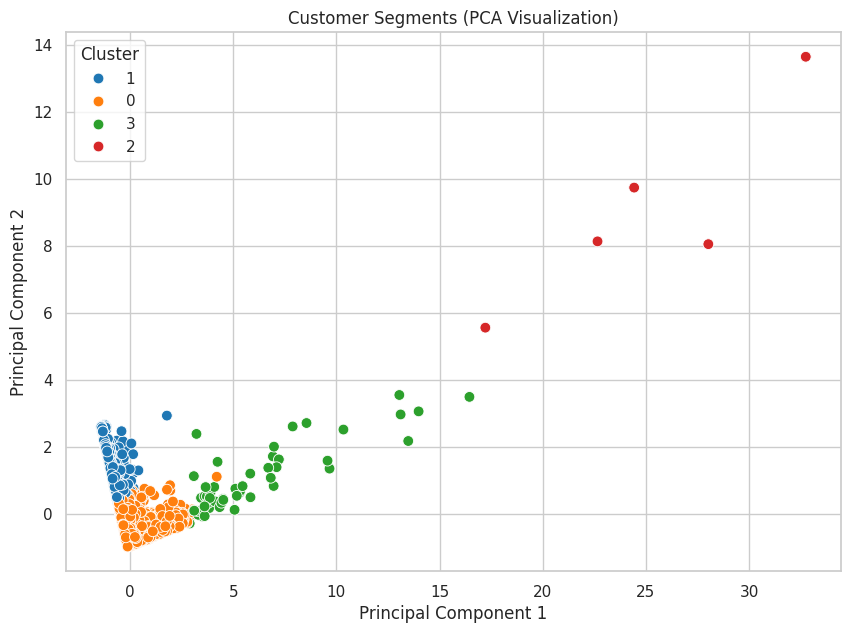

In [20]:

# CELL 12 — PCA CLUSTER VISUALIZATION (NO WARNINGS)
# ============================================================

from sklearn.decomposition import PCA

# Reduce scaled RFM data from 3D → 2D
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Build dataframe including cluster labels
pca_df = pd.DataFrame({
    'PC1': rfm_pca[:, 0],
    'PC2': rfm_pca[:, 1],
    'Cluster': rfm['Cluster'].values   # force alignment
})

# Convert cluster to categorical for clean legend & coloring
pca_df['Cluster'] = pca_df['Cluster'].astype(str)

# Plot clusters
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Cluster',
    palette='tab10',
    s=60
)

plt.title("Customer Segments (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()


In [22]:
# CELL 13 — CUSTOMER LIFETIME VALUE (CLV)
# ============================================================
# CLV approximates how valuable each customer is


rfm['CLV'] = (rfm['Frequency'] * rfm['Monetary']) / (rfm['Recency'] + 1)


# Show top 10 most valuable customers
print("Top 10 High Value Customers:")
rfm.sort_values(by='CLV', ascending=False).head(10)




Top 10 High Value Customers:


,Frequency,Monetary,Recency,Cluster,CLV
Customer ID,,,,,
14911.0,205,152147.57,0,2,3.119025e+07
18102.0,89,349164.35,0,2,3.107563e+07
15311.0,121,56003.26,0,3,6.776394e+06
12748.0,144,22879.66,0,3,3.294671e+06
14156.0,102,196566.74,6,2,2.864258e+06
17841.0,91,29892.50,0,3,2.720218e+06
15061.0,86,83284.38,2,3,2.387486e+06
14646.0,78,248396.50,9,2,1.937493e+06
13089.0,109,57912.03,3,3,1.578103e+06


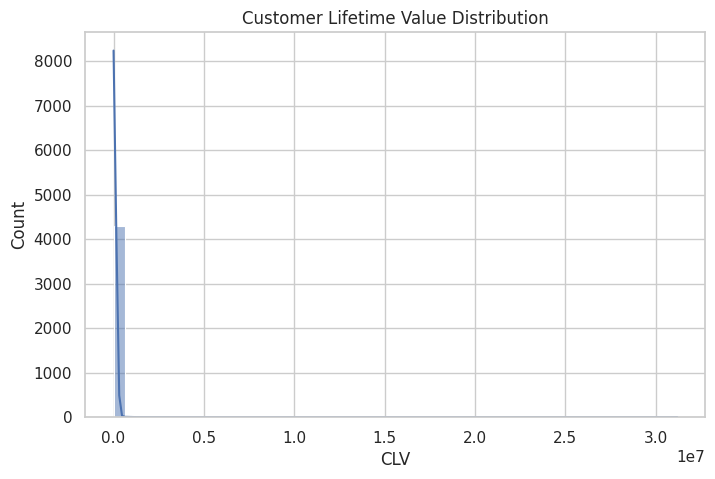

In [23]:

# CELL 14 — CLV DISTRIBUTION VISUALIZATION
# ============================================================
plt.figure(figsize=(8,5))
sns.histplot(rfm['CLV'], bins=50, kde=True)
plt.title("Customer Lifetime Value Distribution")
plt.xlabel("CLV")
plt.show()

In [24]:
# CELL 15 — CLUSTER PROFILING (BUSINESS INTERPRETATION)
# ============================================================
cluster_summary = rfm.groupby('Cluster').agg({
'Recency':'mean',
'Frequency':'mean',
'Monetary':'mean',
'CLV':'mean',
'Cluster':'count'
}).round(2)


print("Cluster Profile Summary:")
cluster_summary

Cluster Profile Summary:


,Recency,Frequency,Monetary,CLV,Cluster
Cluster,,,,,
0,42.00,4.47,1743.13,2723.87,3207
1,241.98,1.66,596.88,7.50,1047
2,4.60,113.60,215543.67,13688096.20,5
3,14.43,48.55,29040.18,571236.00,53


In [28]:
# CELL 16 — DATA-DRIVEN BUSINESS SEGMENTATION
# ============================================================

r25, r50, r75 = rfm['Recency'].quantile([0.25,0.5,0.75])
f25, f50, f75 = rfm['Frequency'].quantile([0.25,0.5,0.75])
m25, m50, m75 = rfm['Monetary'].quantile([0.25,0.5,0.75])

def assign_segment(row):
    if row['Recency'] <= r25 and row['Frequency'] >= f75 and row['Monetary'] >= m75:
        return 'Champions'
    elif row['Frequency'] >= f50 and row['Monetary'] >= m50:
        return 'Loyal Customers'
    elif row['Recency'] >= r75:
        return 'At Risk / Hibernating'
    else:
        return 'New / Potential Customers'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)

rfm[['Recency','Frequency','Monetary','CLV','Segment']].head(10)


,Recency,Frequency,Monetary,CLV,Segment
Customer ID,,,,,
12346.0,164,11,372.86,24.857333,At Risk / Hibernating
12347.0,2,2,1323.32,882.213333,Loyal Customers
12348.0,73,1,222.16,3.002162,New / Potential Customers
12349.0,42,3,2671.14,186.358605,Loyal Customers
12351.0,10,1,300.93,27.357273,New / Potential Customers
12352.0,10,2,343.80,62.509091,New / Potential Customers
12353.0,43,1,317.76,7.221818,New / Potential Customers
12355.0,202,1,488.21,2.404975,At Risk / Hibernating
12356.0,15,3,3562.25,667.921875,Loyal Customers


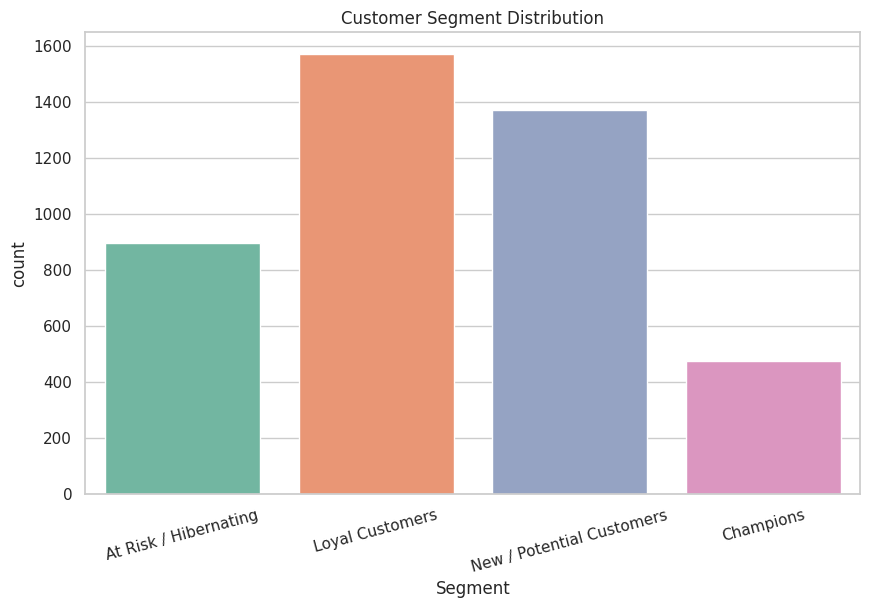

In [29]:
# CELL 17 — SEGMENT DISTRIBUTION 
# ============================================================

plt.figure(figsize=(10,6))

sns.countplot(
    x='Segment',
    data=rfm,
    hue='Segment',
    palette='Set2',
    legend=False
)

plt.title("Customer Segment Distribution")
plt.xticks(rotation=15)
plt.show()


In [32]:
# CELL 18 — DBSCAN CLUSTERING (ADVANCED)
# ============================================================
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.8, min_samples=10)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)

# Show cluster distribution
print("DBSCAN Cluster Distribution:")
rfm['DBSCAN_Cluster'].value_counts()

DBSCAN Cluster Distribution:


DBSCAN_Cluster
 0    4263
-1      49
Name: count, dtype: int64

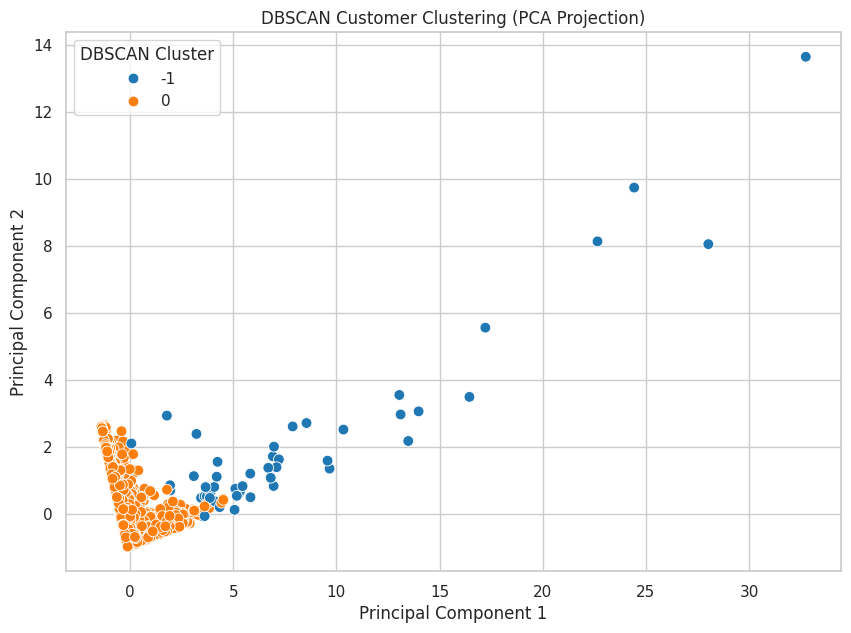

In [33]:
# CELL 19 — DBSCAN VISUALIZATION (PCA)
# ============================================================
# Create fresh PCA DataFrame to avoid index mismatch
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

pca_dbscan_df = pd.DataFrame(pca_components, columns=['PC1','PC2'], index=rfm.index)
pca_dbscan_df['DBSCAN'] = rfm['DBSCAN_Cluster']

# Plot
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=pca_dbscan_df,
    x='PC1', y='PC2',
    hue='DBSCAN',
    palette='tab10',
    s=60
)

plt.title("DBSCAN Customer Clustering (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='DBSCAN Cluster')
plt.show()


In [34]:
#CELL 20 — BUSINESS INSIGHTS FROM CUSTOMER SEGMENTS
# Aggregate business metrics per segment
segment_insights = rfm.groupby('Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'CLV':'mean',
    'Segment':'count'
}).rename(columns={'Segment':'Customer_Count'}).round(2)

print("Business Insights Summary:")
segment_insights


Business Insights Summary:


,Recency,Frequency,Monetary,CLV,Customer_Count
Segment,,,,,
At Risk / Hibernating,246.71,1.34,345.30,2.20,897
Champions,6.57,15.85,9514.05,223943.15,475
Loyal Customers,61.82,5.15,2190.42,647.86,1570
New / Potential Customers,49.15,1.75,411.78,49.04,1370


In [35]:
#CELL 21 — ACTIONABLE BUSINESS RECOMMENDATIONS
# Business strategies mapped to segments
business_recommendations = {
    'Champions': 'Reward loyalty with VIP programs, exclusive discounts, early access to new products, and personalized offers.',
    'Loyal Customers': 'Upsell and cross-sell related products, provide bundle deals, and encourage referrals.',
    'New / Potential Customers': 'Provide onboarding emails, welcome discounts, product recommendations, and trust-building communication.',
    'At Risk / Hibernating': 'Send reactivation campaigns, special discounts, reminders, and limited-time offers to win them back.'
}

# Assign recommendations
rfm['Business_Recommendation'] = rfm['Segment'].map(business_recommendations)

# Preview recommendations
rfm[['Segment','Business_Recommendation']].head(10)


,Segment,Business_Recommendation
Customer ID,,
12346.0,At Risk / Hibernating,"Send reactivation campaigns, special discounts..."
12347.0,Loyal Customers,"Upsell and cross-sell related products, provid..."
12348.0,New / Potential Customers,"Provide onboarding emails, welcome discounts, ..."
12349.0,Loyal Customers,"Upsell and cross-sell related products, provid..."
12351.0,New / Potential Customers,"Provide onboarding emails, welcome discounts, ..."
12352.0,New / Potential Customers,"Provide onboarding emails, welcome discounts, ..."
12353.0,New / Potential Customers,"Provide onboarding emails, welcome discounts, ..."
12355.0,At Risk / Hibernating,"Send reactivation campaigns, special discounts..."
12356.0,Loyal Customers,"Upsell and cross-sell related products, provid..."


In [36]:
#CELL 22 — STRATEGIC BUSINESS SUMMARY
# Print strategic summary
print("\nSTRATEGIC BUSINESS SUMMARY\n" + "="*60)

for seg, rec in business_recommendations.items():
    print(f"\nSegment: {seg}")
    print(f"Recommended Strategy: {rec}")
    print("-"*60)

print("\nCustomer segmentation project completed successfully with business insights and recommendations!")



STRATEGIC BUSINESS SUMMARY

Segment: Champions
Recommended Strategy: Reward loyalty with VIP programs, exclusive discounts, early access to new products, and personalized offers.
------------------------------------------------------------

Segment: Loyal Customers
Recommended Strategy: Upsell and cross-sell related products, provide bundle deals, and encourage referrals.
------------------------------------------------------------

Segment: New / Potential Customers
Recommended Strategy: Provide onboarding emails, welcome discounts, product recommendations, and trust-building communication.
------------------------------------------------------------

Segment: At Risk / Hibernating
Recommended Strategy: Send reactivation campaigns, special discounts, reminders, and limited-time offers to win them back.
------------------------------------------------------------

Customer segmentation project completed successfully with business insights and recommendations!


In [40]:
import joblib

joblib.dump(kmeans, '/kaggle/working/kmeans_model.pkl')
joblib.dump(scaler, '/kaggle/working/scaler.pkl')

print("Model and scaler saved successfully!")


Model and scaler saved successfully!


In [41]:
import zipfile

zip_path = '/kaggle/working/models.zip'

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('/kaggle/working/kmeans_model.pkl', arcname='kmeans_model.pkl')
    zipf.write('/kaggle/working/scaler.pkl', arcname='scaler.pkl')

print("Models zipped successfully!")


Models zipped successfully!


In [42]:
import os
os.listdir('/kaggle/working')


['.virtual_documents', 'kmeans_model.pkl', 'models.zip', 'scaler.pkl']